In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from bs4 import BeautifulSoup
import requests
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



In [2]:
df_2020 = pd.read_csv("transactions_2020.csv")

In [3]:
df_2020.head()

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,...,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
0,12/31/20,14:02:13,Eastern Time (US & Canada),$55.00,$0.00,$55.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZG9G7K92E4535SAB6D5T51WCM0D,01/03/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
1,12/28/20,08:56:42,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZTVSBZATGYX4A10NTWDSBZZSK1S,12/28/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
2,12/27/20,10:17:39,Eastern Time (US & Canada),$130.00,$0.00,$130.00,$0.00,$0.00,$0.00,$0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete,NaN
3,12/26/20,17:06:22,Eastern Time (US & Canada),$60.00,$0.00,$60.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZQD37PXGRE11AHFB5ANKBWR5F2D,12/26/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
4,12/23/20,13:54:09,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZRK59MEZJQ1291F1VYG5XVN2EAS,12/23/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN


In [4]:
df_2020.dtypes

Date                      object
Time                      object
Time Zone                 object
Gross Sales               object
Discounts                 object
Net Sales                 object
Gift Card Sales           object
Tax                       object
Tip                       object
Partial Refunds           object
Total Collected           object
Source                    object
Card                      object
Card Entry Methods        object
Cash                      object
Square Gift Card          object
Other Tender              object
Other Tender Type         object
Other Tender Note         object
Fees                      object
Net Total                 object
Transaction ID            object
Payment ID                object
Card Brand                object
PAN Suffix                object
Device Name               object
Staff Name                object
Staff ID                 float64
Details                   object
Description               object
Event Type

In [5]:
df_2020.isnull().sum()

Date                       0
Time                       0
Time Zone                  0
Gross Sales                0
Discounts                  0
Net Sales                  0
Gift Card Sales            0
Tax                        0
Tip                        0
Partial Refunds            0
Total Collected            0
Source                     0
Card                       0
Card Entry Methods        29
Cash                       0
Square Gift Card           0
Other Tender               0
Other Tender Type        170
Other Tender Note        171
Fees                       0
Net Total                  0
Transaction ID             0
Payment ID                 0
Card Brand                29
PAN Suffix                29
Device Name              120
Staff Name                52
Staff ID                 173
Details                    0
Description                1
Event Type                 0
Location                   0
Dining Option            173
Customer ID                6
Customer Name 

NaN in data frame are not affecting the analysis and/or predictions, so I'll drop the columns with NaN

In [6]:
df_2020.shape

(173, 46)

In [7]:
df_2020.dropna(axis=1, how='all')

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,...,Customer Name,Customer Reference ID,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status
0,12/31/20,14:02:13,Eastern Time (US & Canada),$55.00,$0.00,$55.00,$0.00,$0.00,$0.00,$0.00,...,Brittany Girton,NaN,3ZG9G7K92E4535SAB6D5T51WCM0D,01/03/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
1,12/28/20,08:56:42,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,Clydette Overturf,NaN,3ZTVSBZATGYX4A10NTWDSBZZSK1S,12/28/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
2,12/27/20,10:17:39,Eastern Time (US & Canada),$130.00,$0.00,$130.00,$0.00,$0.00,$0.00,$0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete
3,12/26/20,17:06:22,Eastern Time (US & Canada),$60.00,$0.00,$60.00,$0.00,$0.00,$0.00,$0.00,...,Carrie Moore,NaN,3ZQD37PXGRE11AHFB5ANKBWR5F2D,12/26/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
4,12/23/20,13:54:09,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,Shelby Lewis,NaN,3ZRK59MEZJQ1291F1VYG5XVN2EAS,12/23/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,07/18/20,11:10:23,Eastern Time (US & Canada),$30.00,$0.00,$30.00,$0.00,$0.00,$0.00,$0.00,...,Jacquelyn Rodriguez,NaN,3Z526J4YFC851FDFQ74S3EBVD1RH,07/18/20,https://squareup.com/dashboard/sales/deposits/...,2.6,$0.10,NaN,NaN,Complete
169,07/16/20,11:50:57,Eastern Time (US & Canada),$32.50,$0.00,$32.50,$0.00,$0.00,$0.00,$0.00,...,Bantu Mwaura,NaN,3Z621C42VVAX4S5CQXJGDNY62Y5N,07/16/20,https://squareup.com/dashboard/sales/deposits/...,2.6,$0.10,NaN,NaN,Complete
170,07/09/20,13:05:26,Eastern Time (US & Canada),$40.00,$0.00,$40.00,$0.00,$0.00,$0.00,$0.00,...,Alicia Giangrisostomi,NaN,3Z09QEN1FHJH06BD40D6WKESM199,07/10/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
171,07/08/20,09:15:00,Eastern Time (US & Canada),$20.00,$0.00,$20.00,$0.00,$0.00,$0.00,$0.00,...,Tommy Moore,NaN,3Z09QEN1FHJH06BD40D6WKESM199,07/10/20,https://squareup.com/dashboard/sales/deposits/...,2.6,$0.10,NaN,NaN,Complete


In [8]:
df_2020['Date'] = pd.to_datetime(df_2020['Date'])

In [9]:
df_2020["Gross Sales"] = df_2020["Gross Sales"].replace({'\$':''}, regex = True)

In [10]:
df_2020.at[11, "Gross Sales"] = 1216.80

In [11]:
df_2020['Gross Sales'] = pd.to_numeric(df_2020["Gross Sales"])

In [12]:
df_2020["Gross Sales"].dtypes

dtype('float64')

In [13]:
df_2020["Net Sales"] = df_2020["Net Sales"].replace({'\$':''}, regex = True)

In [14]:
df_2020.at[11, "Net Sales"] = 1216.80

In [15]:
df_2020['Net Sales'] = pd.to_numeric(df_2020["Net Sales"])

In [16]:
df_2020["Net Sales"].dtypes

dtype('float64')

In [17]:
df_2020["Tip"] = df_2020["Tip"].replace({'\$':''}, regex = True)

In [18]:
df_2020['Tip'] = pd.to_numeric(df_2020["Tip"])

In [19]:
df_2020 = df_2020[["Date", "Time", "Gross Sales", "Net Sales", "Tip", "Source"]]

In [20]:
df_2020.head()

,Date,Time,Gross Sales,Net Sales,Tip,Source
0,2020-12-31,14:02:13,55.0,55.0,0.0,Invoices
1,2020-12-28,08:56:42,45.0,45.0,0.0,Invoices
2,2020-12-27,10:17:39,130.0,130.0,0.0,Point of Sale
3,2020-12-26,17:06:22,60.0,60.0,0.0,Invoices
4,2020-12-23,13:54:09,45.0,45.0,0.0,Invoices


In [21]:
df_2020['Time'] = pd.to_datetime(df_2020['Time'])

In [22]:
df_2020['Time'] = pd.to_datetime(df_2020['Time']).dt.time

In [23]:
df_2021 = pd.read_csv("transactions_2021.csv")

In [24]:
df_2021.head()

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,...,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
0,07/10/21,17:12:56,Eastern Time (US & Canada),$46.00,$0.00,$46.00,$0.00,$0.00,$3.00,$0.00,...,NaN,3Z4EAAT7HH810BB9D0QT5J0N1A4X,07/10/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
1,07/10/21,10:16:51,Eastern Time (US & Canada),$131.00,$0.00,$131.00,$0.00,$0.00,$0.00,$0.00,...,NaN,"3ZF9K9K6B4BS475E86YHJV6S5CRH, 3ZJFXBGA94B93EDB...","05/30/21, 07/10/21",https://squareup.com/dashboard/sales/deposits/...,"2.9, 2.9","$0.30, $0.30",NaN,NaN,Complete,NaN
2,07/09/21,16:47:12,Eastern Time (US & Canada),$47.00,$0.00,$47.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZSTS0ENJM2D4QD6HTJYCPSENG2H,07/09/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
3,07/09/21,08:56:50,Eastern Time (US & Canada),$60.00,$0.00,$60.00,$0.00,$0.00,$0.00,$0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete,NaN
4,07/08/21,18:38:38,Eastern Time (US & Canada),$55.00,$0.00,$55.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZFV8KHWKDN55NN8WBHGHEWSXRVN,07/08/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN


In [25]:
df_2021.dtypes

Date                      object
Time                      object
Time Zone                 object
Gross Sales               object
Discounts                 object
Net Sales                 object
Gift Card Sales           object
Tax                       object
Tip                       object
Partial Refunds           object
Total Collected           object
Source                    object
Card                      object
Card Entry Methods        object
Cash                      object
Square Gift Card          object
Other Tender              object
Other Tender Type         object
Other Tender Note         object
Fees                      object
Net Total                 object
Transaction ID            object
Payment ID                object
Card Brand                object
PAN Suffix                object
Device Name               object
Staff Name                object
Staff ID                 float64
Details                   object
Description               object
Event Type

In [26]:
df_2021.isnull().sum()

Date                       0
Time                       0
Time Zone                  0
Gross Sales                0
Discounts                  0
Net Sales                  0
Gift Card Sales            0
Tax                        0
Tip                        0
Partial Refunds            0
Total Collected            0
Source                     0
Card                       0
Card Entry Methods        37
Cash                       0
Square Gift Card           0
Other Tender               0
Other Tender Type        262
Other Tender Note        263
Fees                       0
Net Total                  0
Transaction ID             0
Payment ID                 0
Card Brand                37
PAN Suffix                37
Device Name              227
Staff Name                45
Staff ID                 267
Details                    0
Description                2
Event Type                 0
Location                   0
Dining Option            267
Customer ID               27
Customer Name 

In [27]:
df_2021.shape

(267, 46)

In [28]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])


In [29]:
df_2021['Time'] = pd.to_datetime(df_2021['Time'])

In [30]:
df_2021["Time"]

0     2021-07-18 17:12:56
1     2021-07-18 10:16:51
2     2021-07-18 16:47:12
3     2021-07-18 08:56:50
4     2021-07-18 18:38:38
              ...        
262   2021-07-18 09:06:12
263   2021-07-18 11:42:21
264   2021-07-18 12:58:16
265   2021-07-18 19:07:01
266   2021-07-18 09:46:23
Name: Time, Length: 267, dtype: datetime64[ns]

In [31]:
df_2021['Time'] = pd.to_datetime(df_2021['Time']).dt.time

In [32]:
df_2021["Gross Sales"] = df_2021["Gross Sales"].replace({'\$':''}, regex = True)


In [33]:
df_2021["Net Sales"] = df_2021["Net Sales"].replace({'\$':''}, regex = True)
df_2021["Tip"] = df_2021["Tip"].replace({'\$':''}, regex = True)

In [34]:
df_2021['Tip'] = pd.to_numeric(df_2021["Tip"])

In [35]:
df_2021 = df_2021[["Date", "Time", "Gross Sales", "Net Sales", "Tip", "Source"]]

In [36]:
df_2021.head()

,Date,Time,Gross Sales,Net Sales,Tip,Source
0,2021-07-10,17:12:56,46.00,46.00,3.0,Invoices
1,2021-07-10,10:16:51,131.00,131.00,0.0,Invoices
2,2021-07-09,16:47:12,47.00,47.00,0.0,Invoices
3,2021-07-09,08:56:50,60.00,60.00,0.0,Point of Sale
4,2021-07-08,18:38:38,55.00,55.00,0.0,Invoices


In [37]:
df_sales = df_2020.append(df_2021)

In [38]:
df_sales.head()

,Date,Time,Gross Sales,Net Sales,Tip,Source
0,2020-12-31,14:02:13,55,55,0.0,Invoices
1,2020-12-28,08:56:42,45,45,0.0,Invoices
2,2020-12-27,10:17:39,130,130,0.0,Point of Sale
3,2020-12-26,17:06:22,60,60,0.0,Invoices
4,2020-12-23,13:54:09,45,45,0.0,Invoices


In [39]:
df_sales.shape

(440, 6)

In [40]:
df_sales.to_csv("df_sales.csv")

In [41]:
df_traffic_2021 = pd.read_csv("traffic-over-time_2021.csv")

In [42]:
df_traffic_2021

,Day,Page Views,Site Sessions ⓘ,Unique Visitors,Site Bounce Rate ⓘ,Avg. Session Duration ⓘ
0,2021-07-11,192,19,15,26.00%,06m 53s
1,2021-04-17,144,33,28,36.00%,03m 06s
2,2021-03-30,144,27,26,37.00%,04m 05s
3,2021-04-19,137,37,36,49.00%,02m 35s
4,2021-05-13,132,32,29,41.00%,02m 50s
...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,00m 14s
195,2021-02-05,17,8,8,38.00%,01m 38s
196,2021-01-28,16,7,7,57.00%,00m 42s
197,2021-01-31,14,9,9,78.00%,00m 25s


In [43]:
df_traffic_2020 = pd.read_csv("traffic-over-time_2020.csv")

In [44]:
df_traffic = df_traffic_2020.append(df_traffic_2021)

In [45]:
df_traffic

,Day,Page Views,Site Sessions ⓘ,Unique Visitors,Site Bounce Rate ⓘ,Avg. Session Duration ⓘ
0,2020-12-10,104,14,11,21.00%,10m 01s
1,2020-06-30,93,17,17,59.00%,01m 32s
2,2020-08-06,87,15,10,33.00%,08m 04s
3,2020-06-25,86,10,5,60.00%,00m 55s
4,2020-12-14,83,26,24,42.00%,02m 07s
...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,00m 14s
195,2021-02-05,17,8,8,38.00%,01m 38s
196,2021-01-28,16,7,7,57.00%,00m 42s
197,2021-01-31,14,9,9,78.00%,00m 25s


In [46]:
df_traffic.columns = ["Date", "Page_Views", "Site_Sessions", "Unique_Visitor", "Site_Bounce_Rate", "Avg.Session_Duration"]

In [47]:
df_traffic['Date'] = pd.to_datetime(df_traffic['Date'])

In [48]:
df_traffic.describe()

,Page_Views,Site_Sessions,Unique_Visitor
count,435.000000,435.000000,435.000000
mean,42.379310,12.772414,11.622989
std,32.491701,7.509820,6.863073
min,1.000000,1.000000,1.000000
25%,17.500000,7.000000,7.000000
50%,34.000000,12.000000,11.000000
75%,60.000000,18.000000,16.000000
max,192.000000,37.000000,36.000000


In [49]:
# new data frame with split value columns
minutes_traffic = df_traffic["Avg.Session_Duration"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
df_traffic["Session_minutes"]= minutes_traffic[0]
  
# making separate last name column from new data frame
df_traffic["Session_seconds"]= minutes_traffic[1]
  

df_traffic

,Date,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Avg.Session_Duration,Session_minutes,Session_seconds
0,2020-12-10,104,14,11,21.00%,10m 01s,10m,01s
1,2020-06-30,93,17,17,59.00%,01m 32s,01m,32s
2,2020-08-06,87,15,10,33.00%,08m 04s,08m,04s
3,2020-06-25,86,10,5,60.00%,00m 55s,00m,55s
4,2020-12-14,83,26,24,42.00%,02m 07s,02m,07s
...,...,...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,00m 14s,00m,14s
195,2021-02-05,17,8,8,38.00%,01m 38s,01m,38s
196,2021-01-28,16,7,7,57.00%,00m 42s,00m,42s
197,2021-01-31,14,9,9,78.00%,00m 25s,00m,25s


In [50]:
df_traffic.drop(columns =["Avg.Session_Duration"], inplace = True)

In [51]:
df_traffic["Session_minutes"] = df_traffic["Session_minutes"].replace({'m':''}, regex = True)

In [52]:
df_traffic["Session_seconds"] = df_traffic["Session_seconds"].replace({'s':''}, regex = True)

In [53]:
df_traffic["Session_minutes"] = df_traffic["Session_minutes"].astype(int)

In [54]:
df_traffic.dtypes

Date                datetime64[ns]
Page_Views                   int64
Site_Sessions                int64
Unique_Visitor               int64
Site_Bounce_Rate            object
Session_minutes              int32
Session_seconds             object
dtype: object

In [55]:
df_traffic["Session_minutes"] = 60*df_traffic["Session_minutes"]

In [56]:
df_traffic["Session_seconds"] = df_traffic["Session_seconds"].astype(int)

In [57]:
df_traffic["Sess_durat"] = df_traffic["Session_minutes"] + df_traffic["Session_seconds"]

In [58]:
df_traffic.drop(columns =["Session_minutes", "Session_seconds"], inplace = True)

In [59]:
df_traffic

,Date,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Sess_durat
0,2020-12-10,104,14,11,21.00%,601
1,2020-06-30,93,17,17,59.00%,92
2,2020-08-06,87,15,10,33.00%,484
3,2020-06-25,86,10,5,60.00%,55
4,2020-12-14,83,26,24,42.00%,127
...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,14
195,2021-02-05,17,8,8,38.00%,98
196,2021-01-28,16,7,7,57.00%,42
197,2021-01-31,14,9,9,78.00%,25


In [60]:
df_traffic.to_csv("df_Traffic.csv")

In [61]:
df_1 = pd.merge(df_sales, df_traffic, how="inner", on="Date")

In [62]:
df_1

,Date,Time,Gross Sales,Net Sales,Tip,Source,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Sess_durat
0,2020-12-31,14:02:13,55,55,0.0,Invoices,11,6,6,67.00%,32
1,2020-12-28,08:56:42,45,45,0.0,Invoices,30,9,9,44.00%,235
2,2020-12-27,10:17:39,130,130,0.0,Point of Sale,15,7,7,57.00%,7
3,2020-12-26,17:06:22,60,60,0.0,Invoices,30,12,10,50.00%,89
4,2020-12-23,13:54:09,45,45,0.0,Invoices,19,10,10,70.00%,20
...,...,...,...,...,...,...,...,...,...,...,...
435,2021-01-07,09:06:12,150.00,150.00,0.0,Invoices,23,10,9,60.00%,93
436,2021-01-06,11:42:21,55.00,55.00,0.0,Invoices,26,10,10,40.00%,46
437,2021-01-05,12:58:16,360.00,360.00,0.0,Point of Sale,17,8,8,75.00%,14
438,2021-01-02,19:07:01,75.00,75.00,0.0,Invoices,32,6,6,17.00%,83


In [63]:
df_1["Gross Sales"] = df_1["Gross Sales"].astype(float)

In [64]:
df_1["Net Sales"] = df_1["Net Sales"].astype(float)

In [65]:
df_1.to_csv("df_final1.csv")

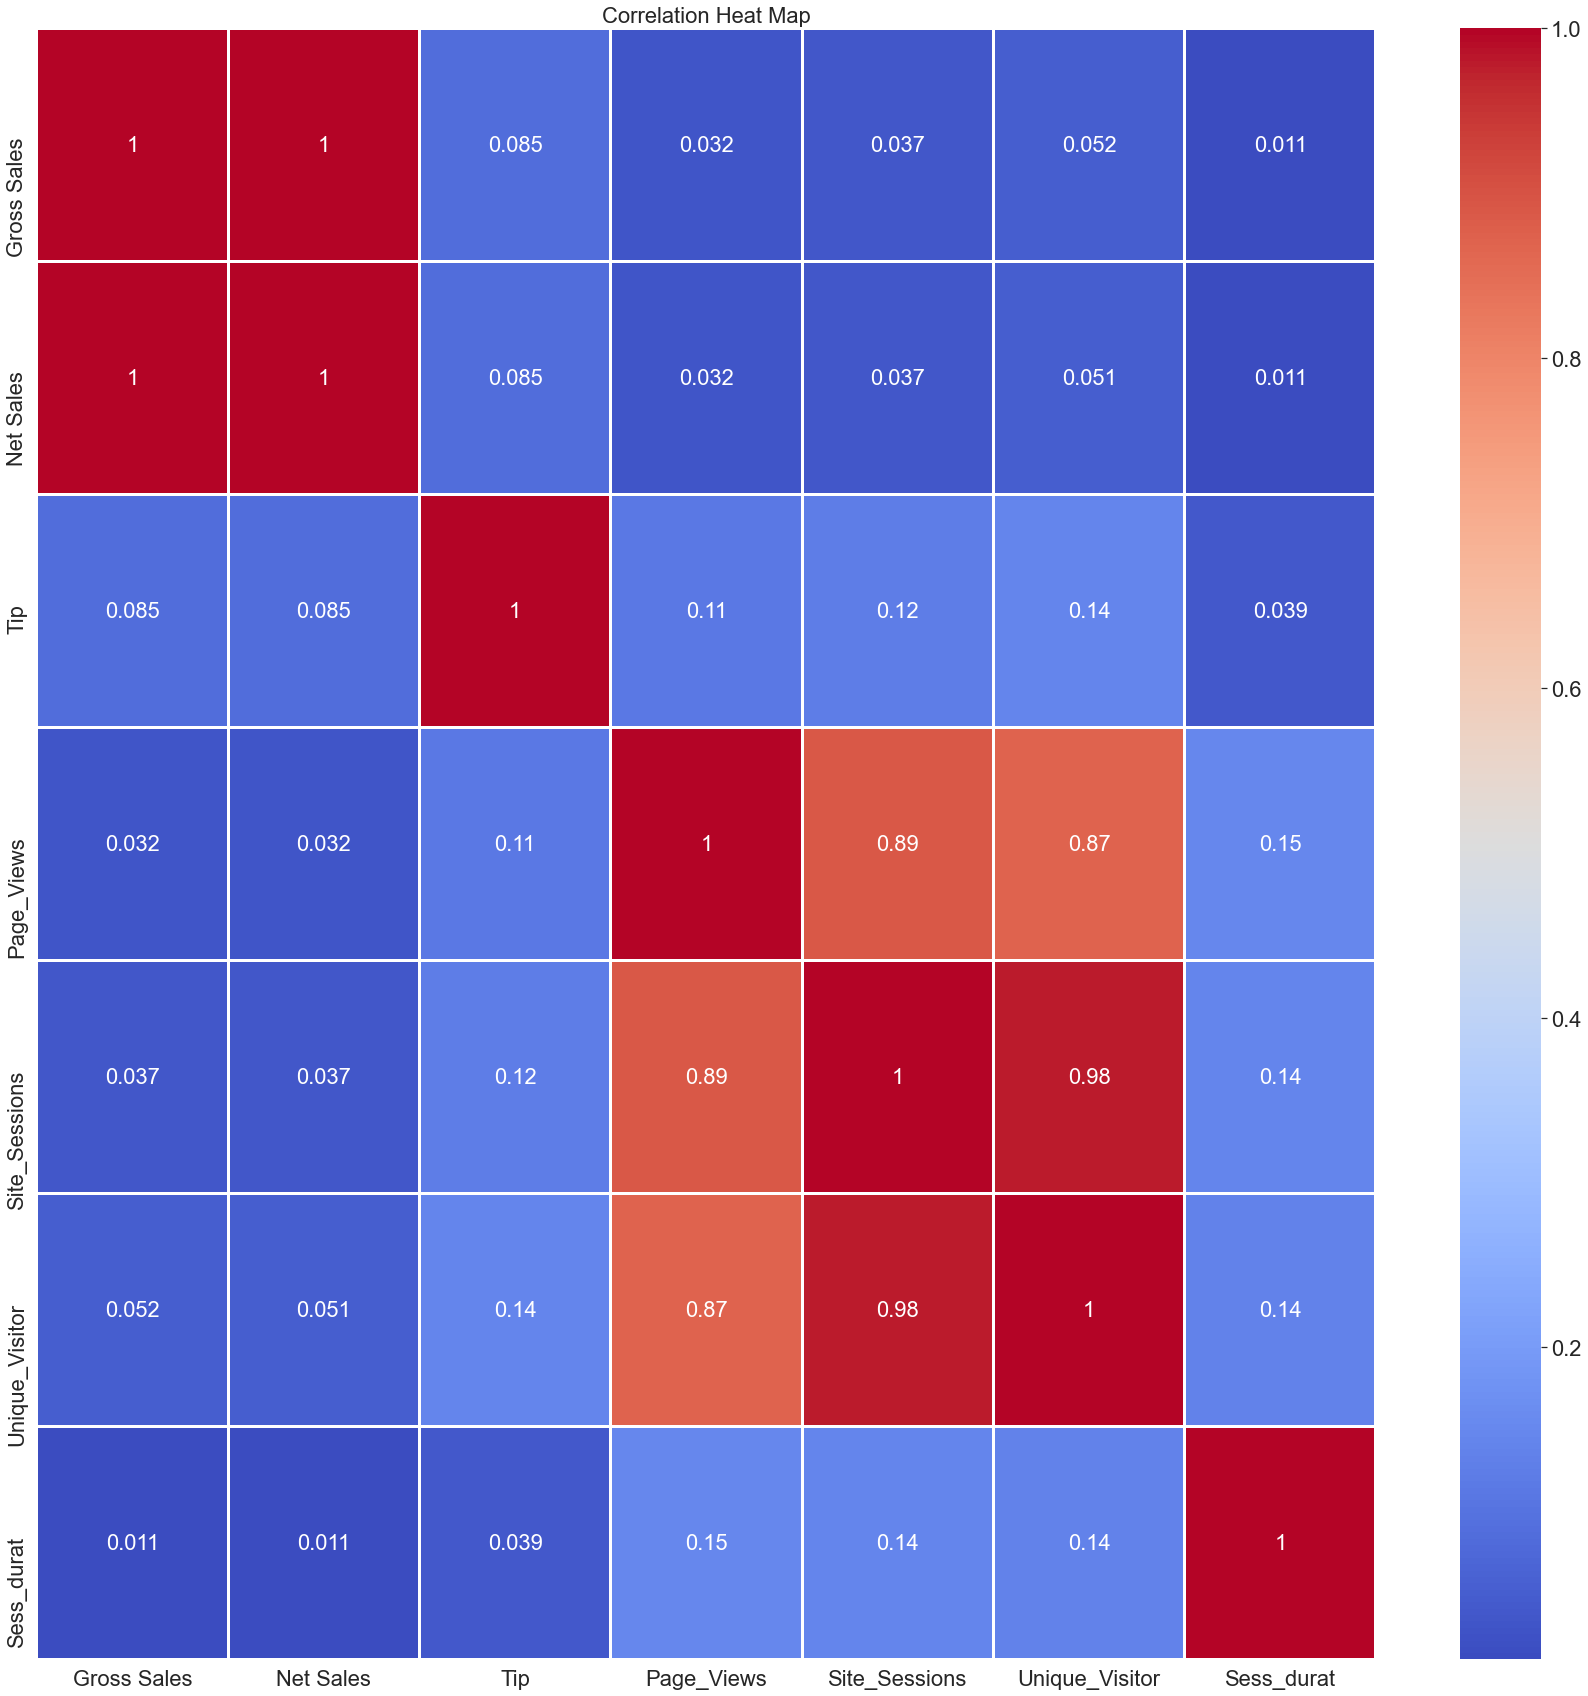

In [66]:
import seaborn as sns

sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
sns.heatmap(df_1.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2, annot_kws={"size": 22})
plt.title('Correlation Heat Map', fontsize = 22)
plt.show()

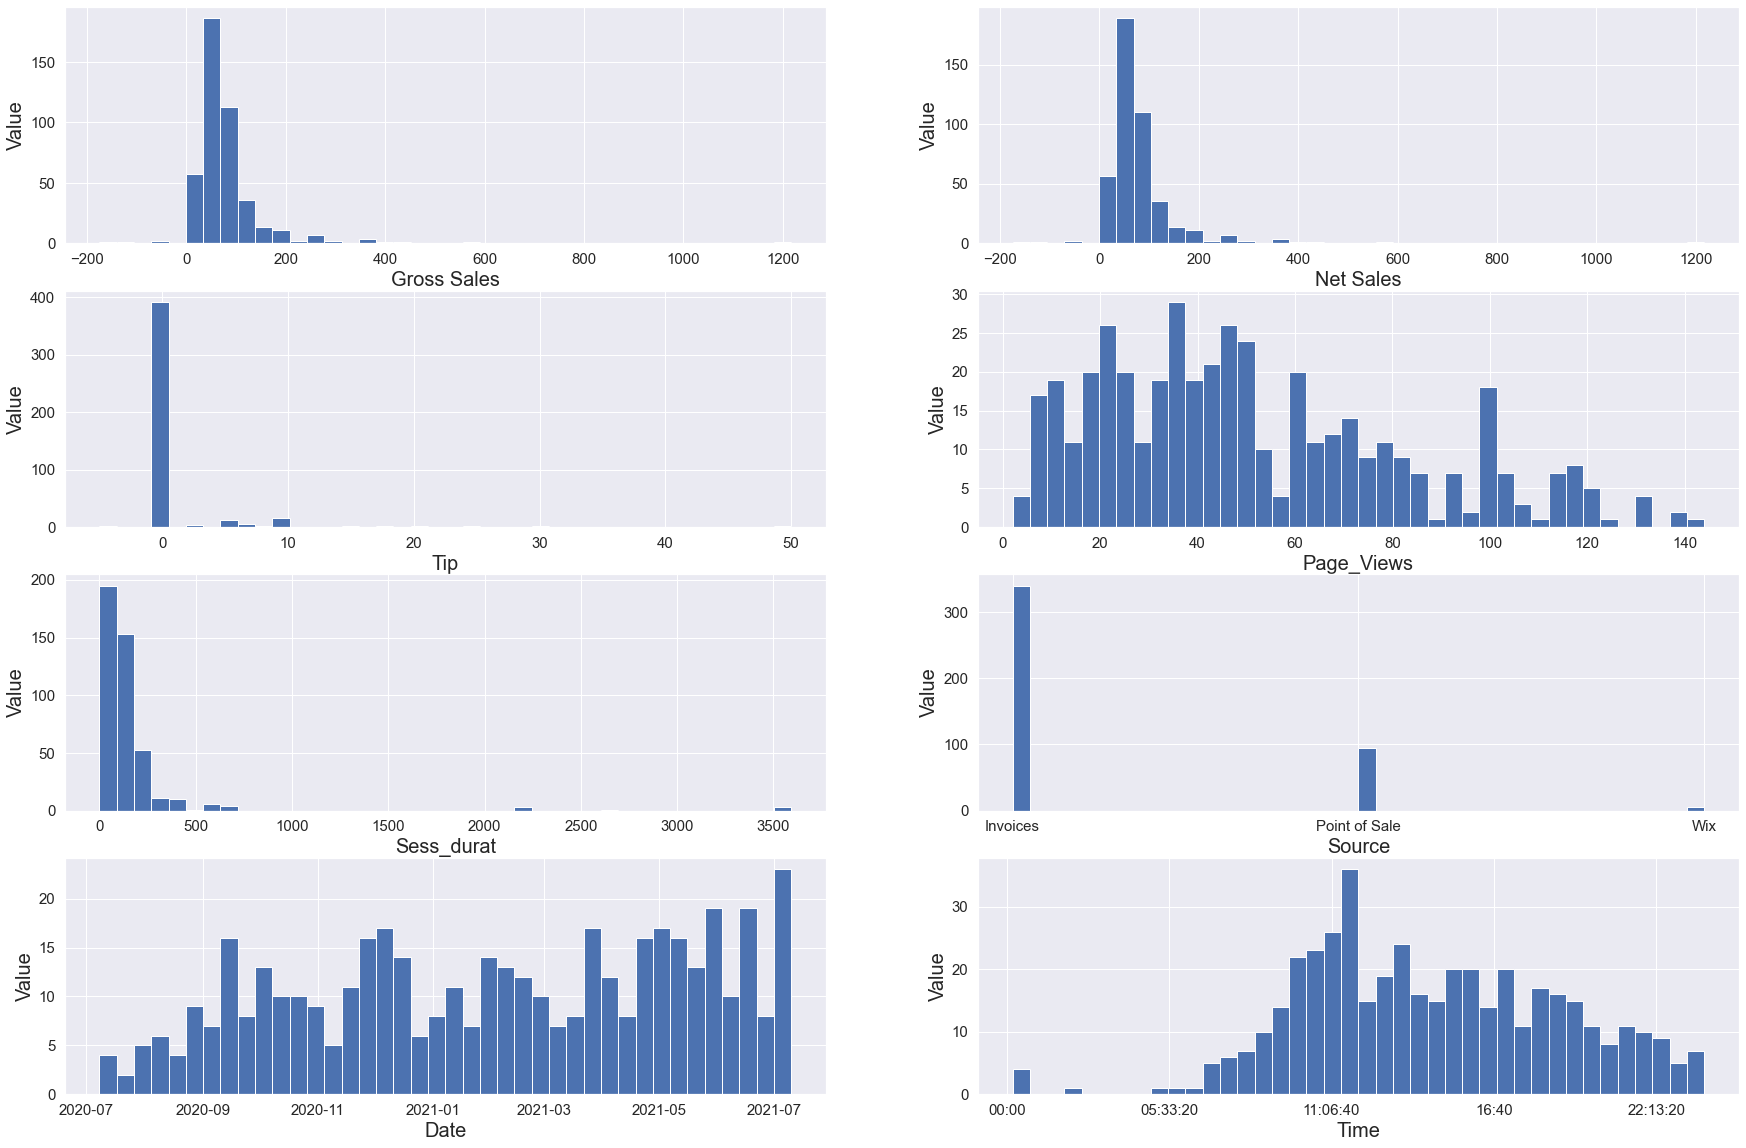

In [67]:
plt.rcParams['figure.figsize'] = (30, 20)

fig, axes = plt.subplots(nrows = 4, ncols = 2)

# Specify the features of interest
num_features = ['Gross Sales', 'Net Sales', 'Tip', 'Page_Views', 'Sess_durat', 'Source', 'Date', "Time"]
xaxes = num_features
yaxes = ['Value', 'Value', 'Value', 'Value', 'Value', 'Value', 'Value', 'Value']


# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(df_1[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)

plt.show()

In [68]:
from sklearn import linear_model

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [70]:
df_model = df_1

In [71]:
import datetime as dt

In [72]:
df_model['Date']=df_model['Date'].map(dt.datetime.toordinal)

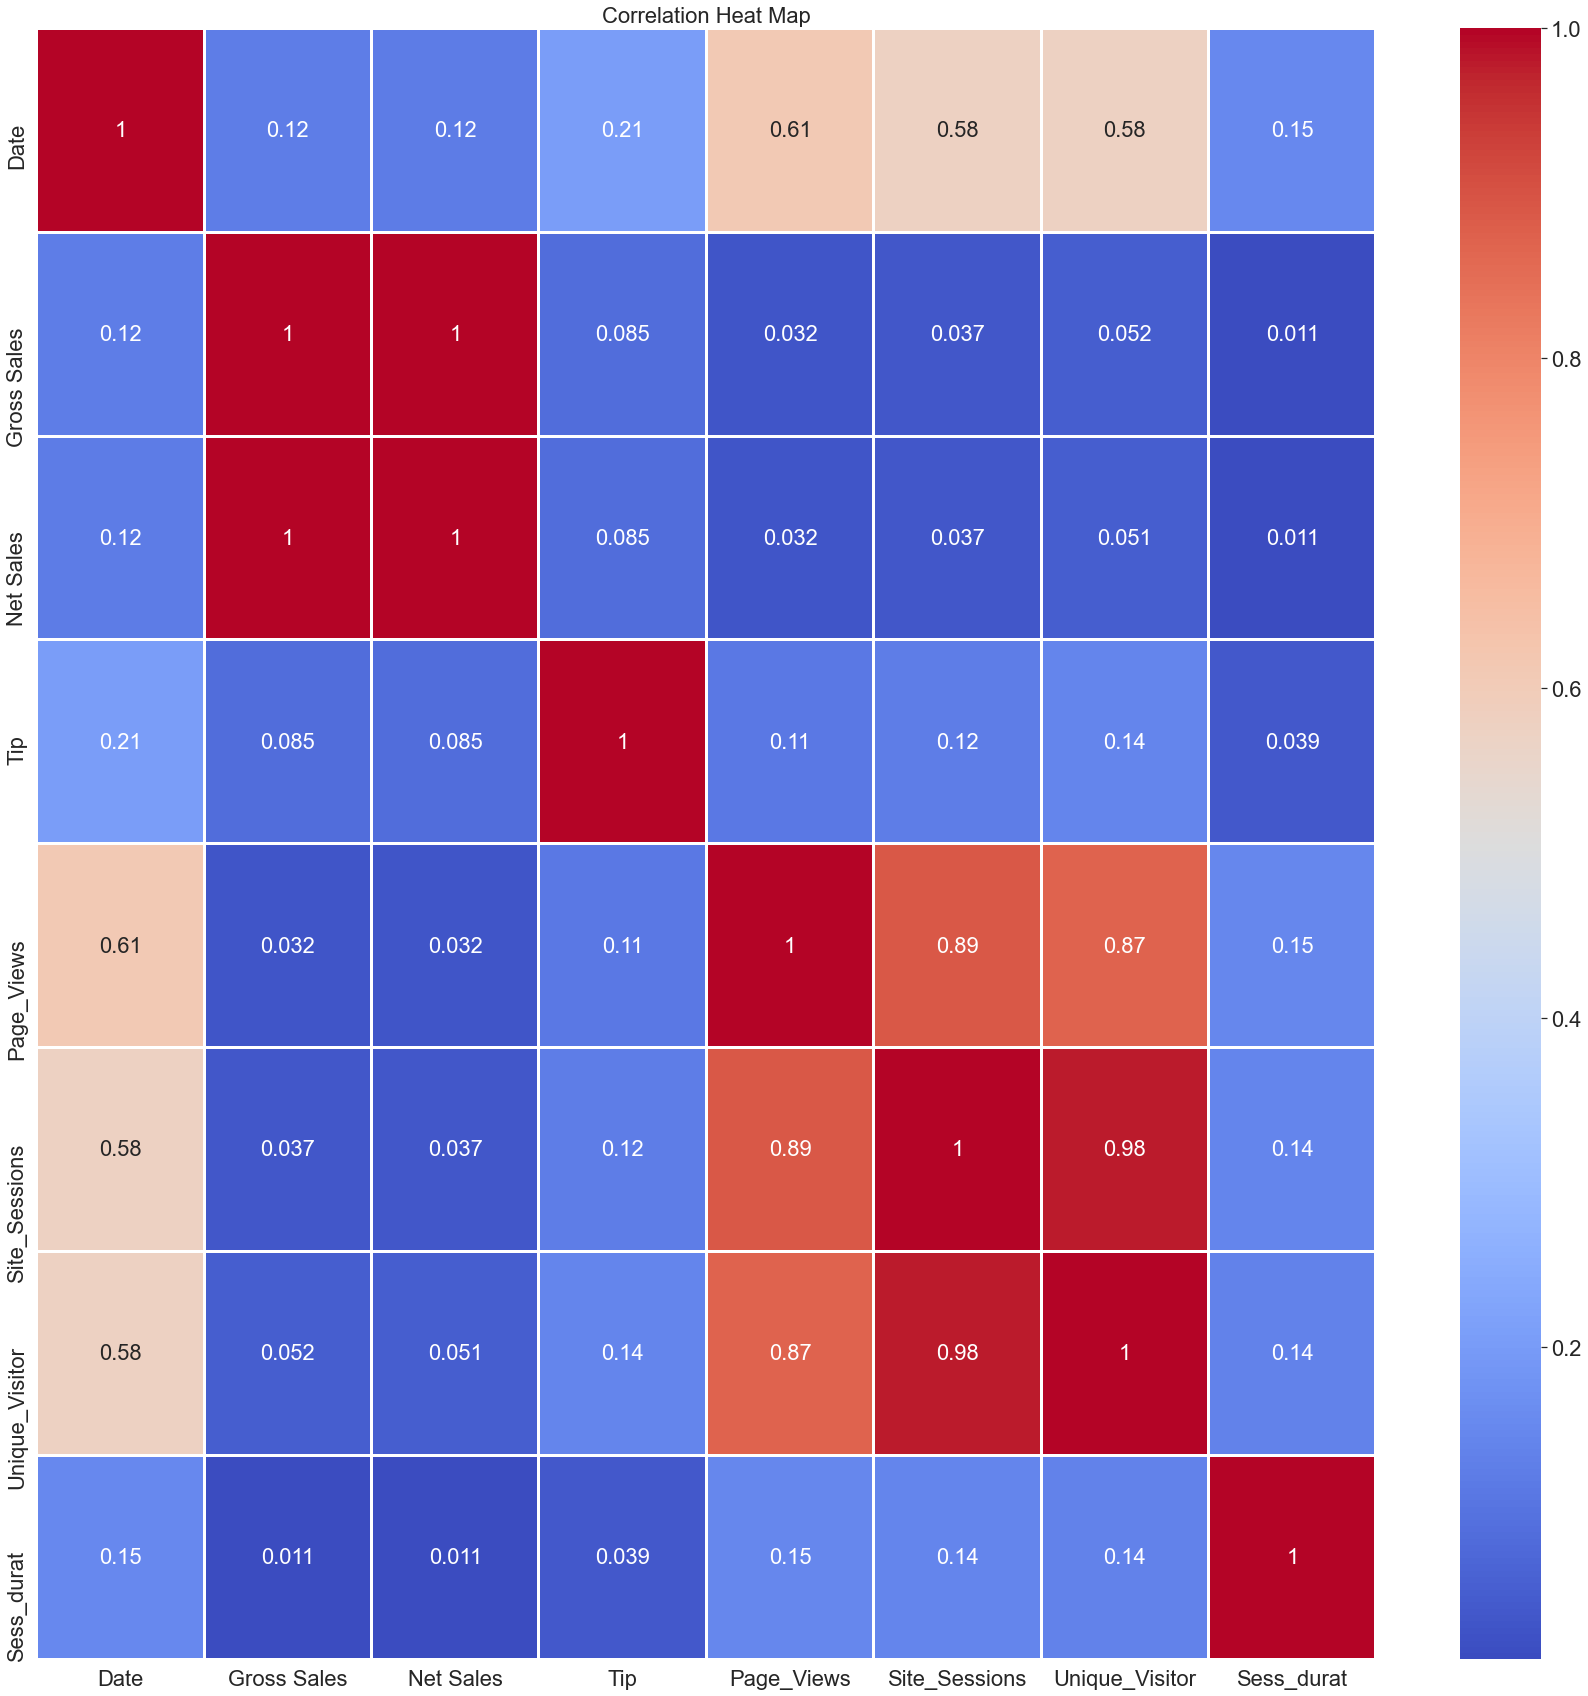

In [73]:
sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
sns.heatmap(df_model.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2, annot_kws={"size": 22})
plt.title('Correlation Heat Map', fontsize = 22)
plt.show()

In [74]:
df_model.drop(columns = "Gross Sales", inplace = True)

In [80]:
df_model.drop(columns = "Time", inplace=True)


In [89]:
df_model.drop(columns = "Source", inplace=True)

In [93]:
df_model.drop(columns = "Site_Bounce_Rate", inplace=True)

In [94]:
target = df_model["Net Sales"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df_model.loc[:, df_model.columns != 'Net Sales'], target, test_size=0.5, random_state=22)

In [96]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [97]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('R2: \n', regr.score(X_train,y_train))

Intercept: 
 -91924.75741959903
Coefficients: 
 [ 0.12470749  2.65828951 -0.2898854  -0.59815036  0.79969485 -0.00391155]
R2: 
 0.03539750723692059


In [98]:
y_pred = regr.predict(X_test)

In [99]:
y_pred

array([ 69.72171941,  81.54290539,  85.12357469,  55.26047232,
        72.16596565,  97.06062403,  73.98821046,  74.72408987,
        70.81723455,  85.12357469,  85.63570173,  78.24214836,
       118.08995852,  70.61834699,  83.8884323 ,  66.75723248,
        63.18723216,  73.37004216,  93.41625677,  68.004751  ,
        74.33550096,  83.95324986,  74.37641572,  79.81662348,
        61.79709721,  67.36097091,  70.12703625,  75.68945522,
        77.79984154,  77.64320536,  70.93486587, 106.60727164,
        60.20949396,  69.16619873,  83.97502621,  64.28409457,
       113.92643612, 109.95121488,  75.26397372,  68.98317557,
        62.22393144,  83.4996707 ,  81.81332831,  79.80669147,
        79.51610444,  83.4996707 ,  79.00267115,  56.08999433,
        89.64081005,  80.880596  ,  71.13115545,  85.81831614,
        77.89686826,  77.34398649,  62.87106251,  62.87106251,
        76.050703  ,  70.93486587,  72.09286536,  69.47744661,
       103.44251571,  68.63161059, 104.06911769,  90.22

In [101]:
y_test.shape

(220,)

In [102]:
y_pred.shape

(220,)

In [108]:
y_test = np.array(list(y_train))
y_pred = np.array(y_pred)

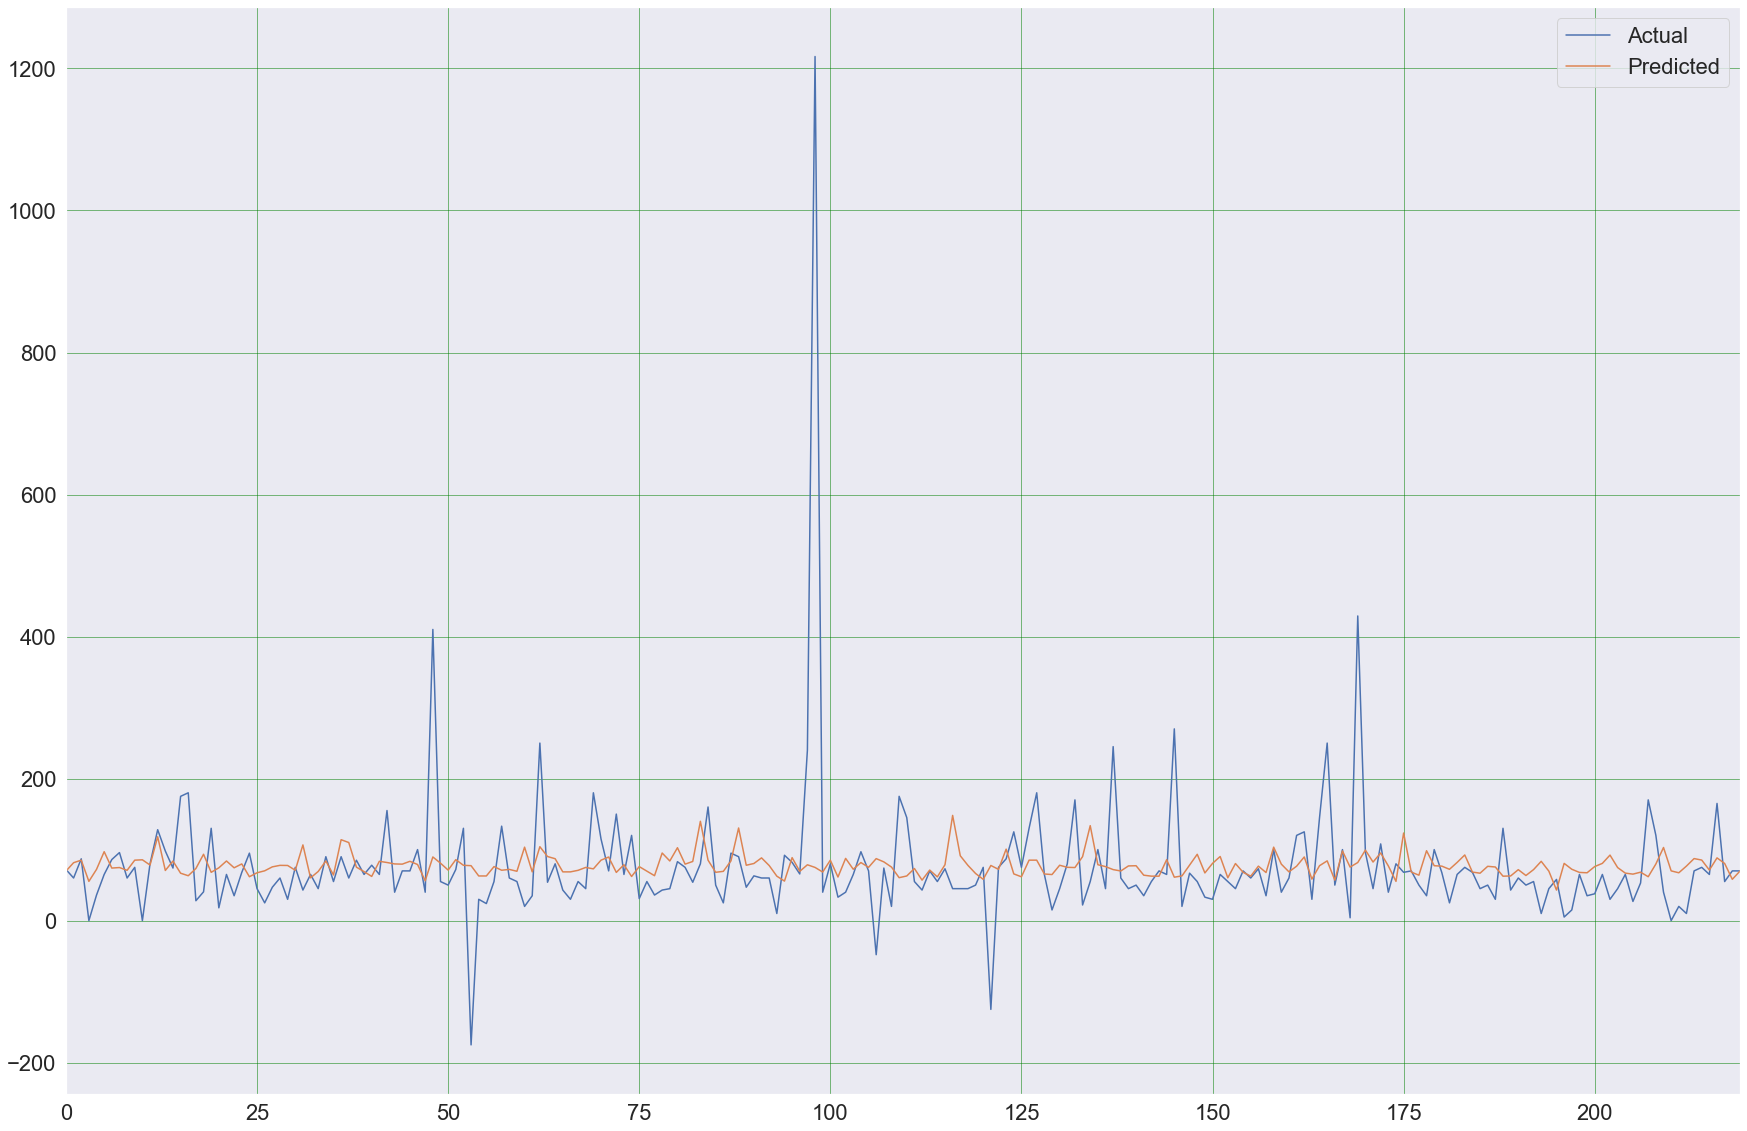

In [110]:
df1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df1.plot(kind='line')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

ValueError: x and y must be the same size

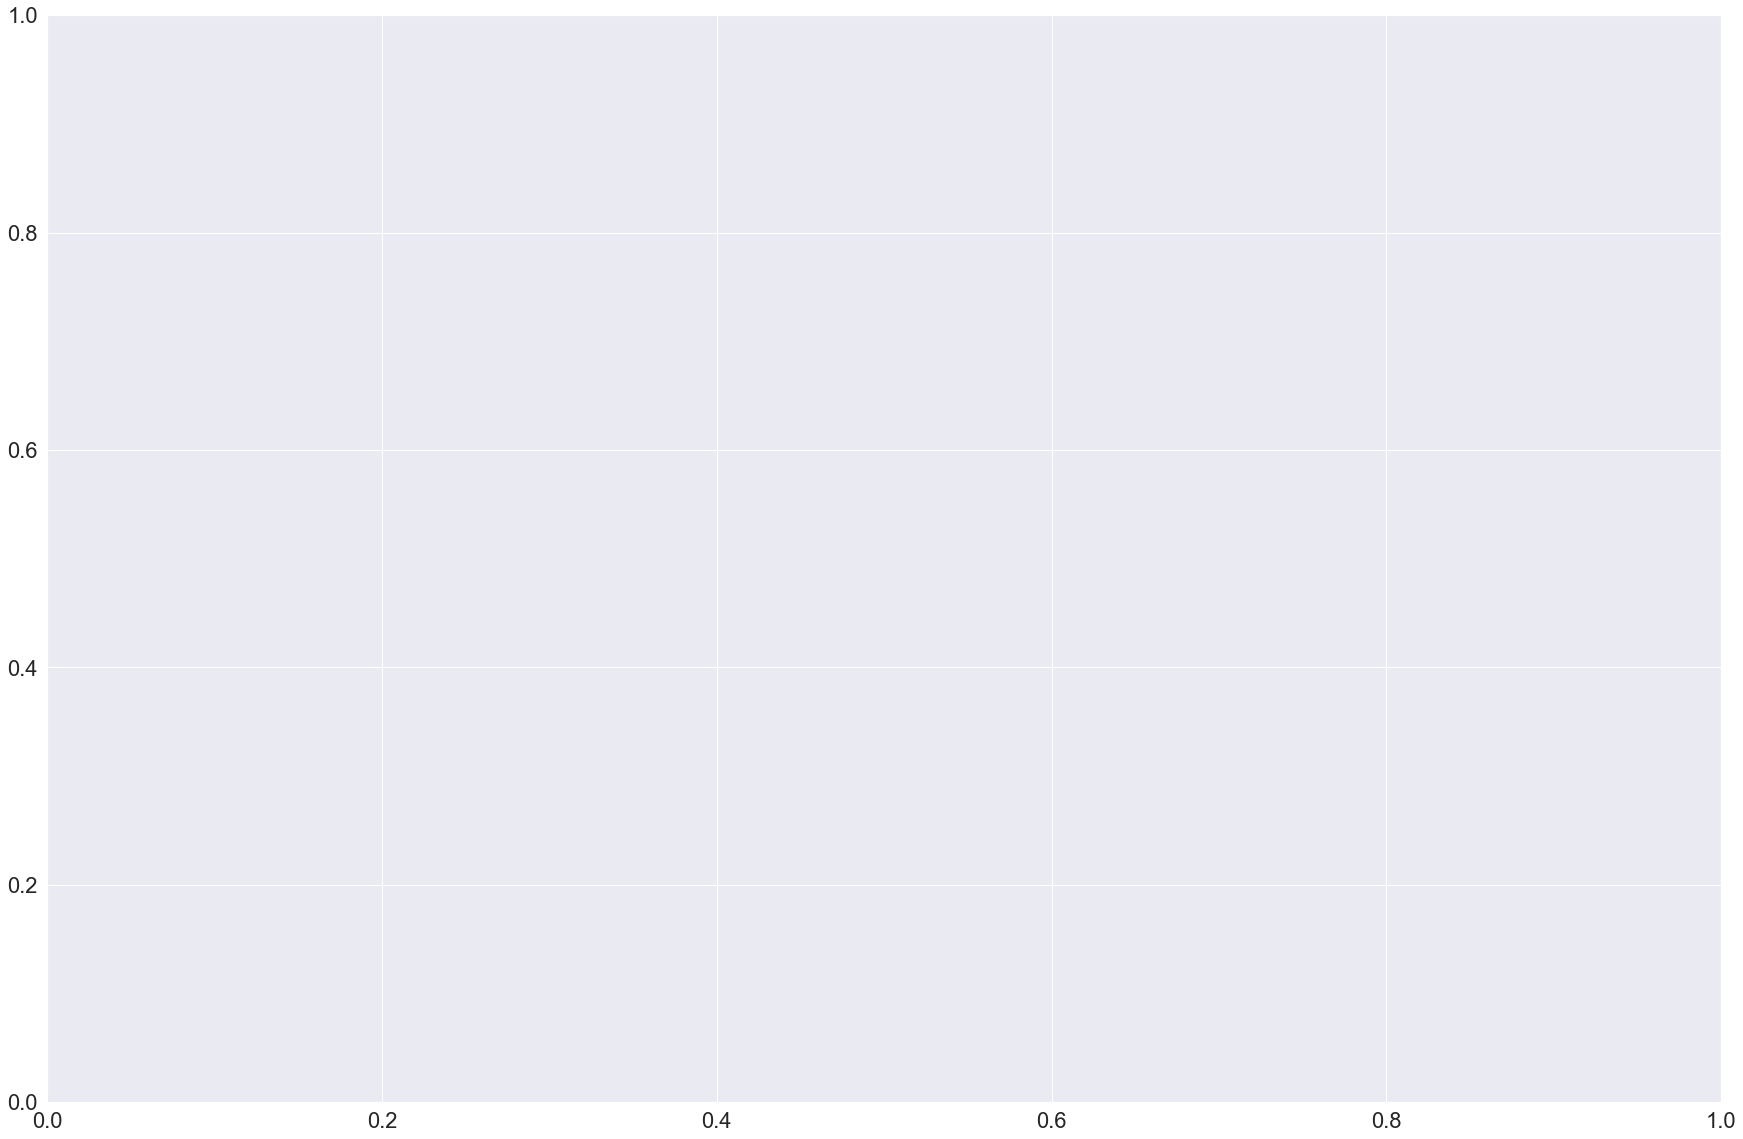

In [113]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_poly, y_train)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X_test, y_test, color='red')
    plt.plot(X_test, pol_reg.predict(poly_reg.fit_transform(X_train)), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()